In [1]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


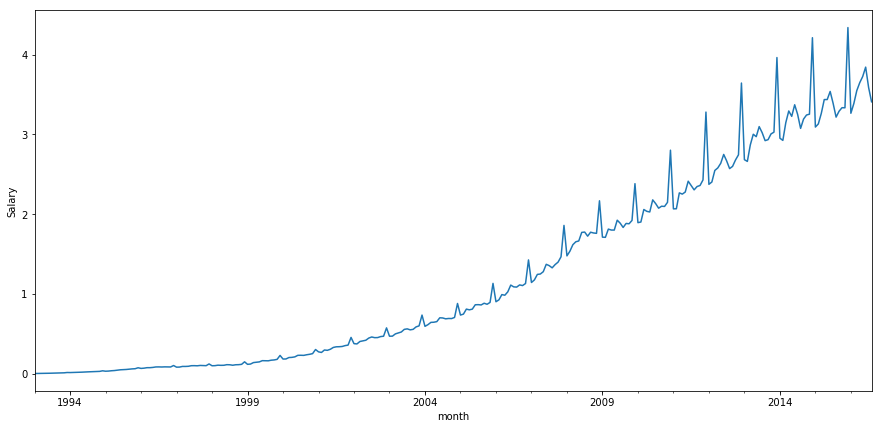

In [6]:
salary = pd.read_csv('WAG_C_M.csv',';', index_col=['month'], parse_dates=['month'], dayfirst=True)
plt.figure(figsize(15,7))
salary.WAG_C_M /= 10000
salary.WAG_C_M.plot()
plt.ylabel('Salary')
pylab.show()

Проверка стационарности и STL-декомпозиция ряда:

Критерий Дики-Фуллера: p=0.991850


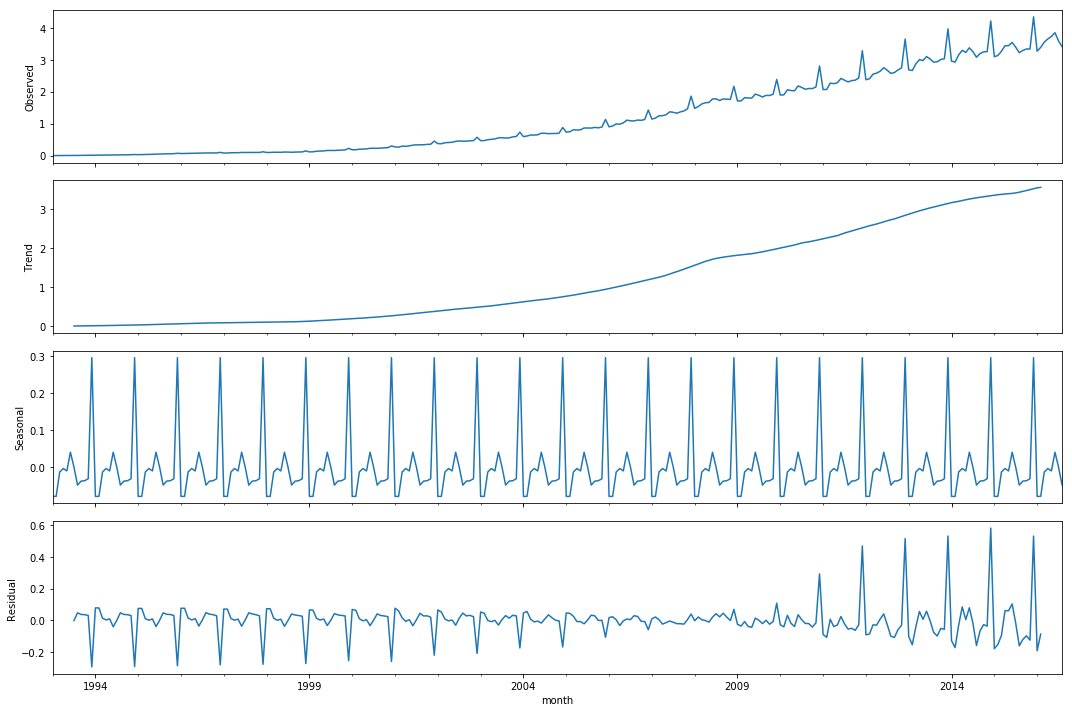

In [9]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(salary.WAG_C_M).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary.WAG_C_M)[1])

### Стабилизация дисперсии

Сделаем преобразование Бокса-Кокса для стабилизации дисперсии:

Оптимальный параметр преобразования Бокса-Кокса: 0.263202
Критерий Дики-Фуллера: p=0.696899


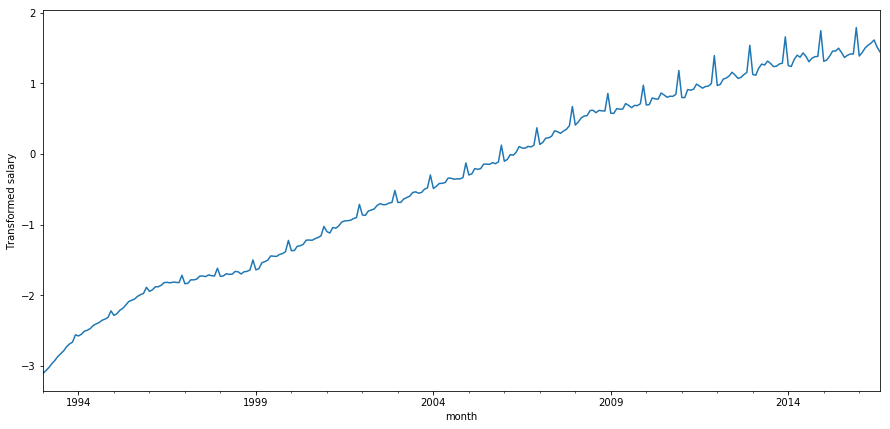

In [11]:
salary['salary_box'], lmbda = stats.boxcox(salary.WAG_C_M)
plt.figure(figsize(15,7))
salary.salary_box.plot()
plt.ylabel(u'Transformed salary')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary.salary_box)[1])

### Стационарность

Попробуем сезонное дифференцирование; сделаем на продифференцированном ряде STL-декомпозицию и проверим стационарность:

Критерий Дики-Фуллера: p=0.014697


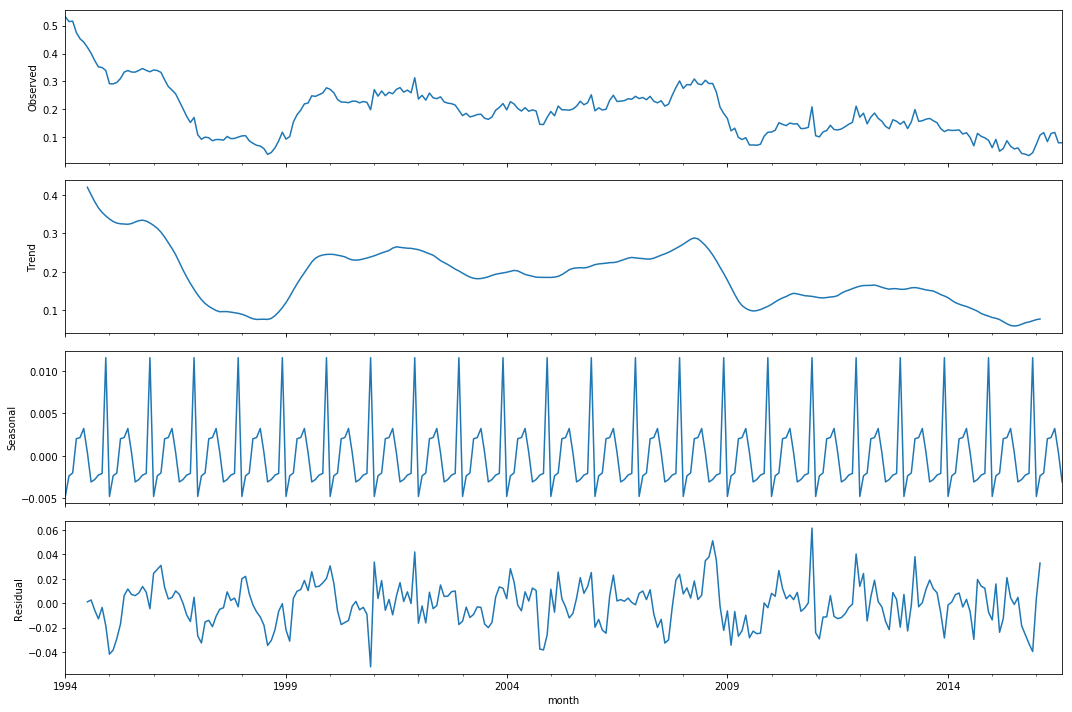

In [16]:
salary['salary_box_diff'] = salary.salary_box - salary.salary_box.shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(salary.salary_box_diff[12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary.salary_box_diff[12:])[1])

Критерий Дики-Фуллера не отвергает гипотезу нестационарности, и полностью избавиться от тренда не удалось. Попробуем добавить ещё обычное дифференцирование:

Критерий Дики-Фуллера: p=0.000000


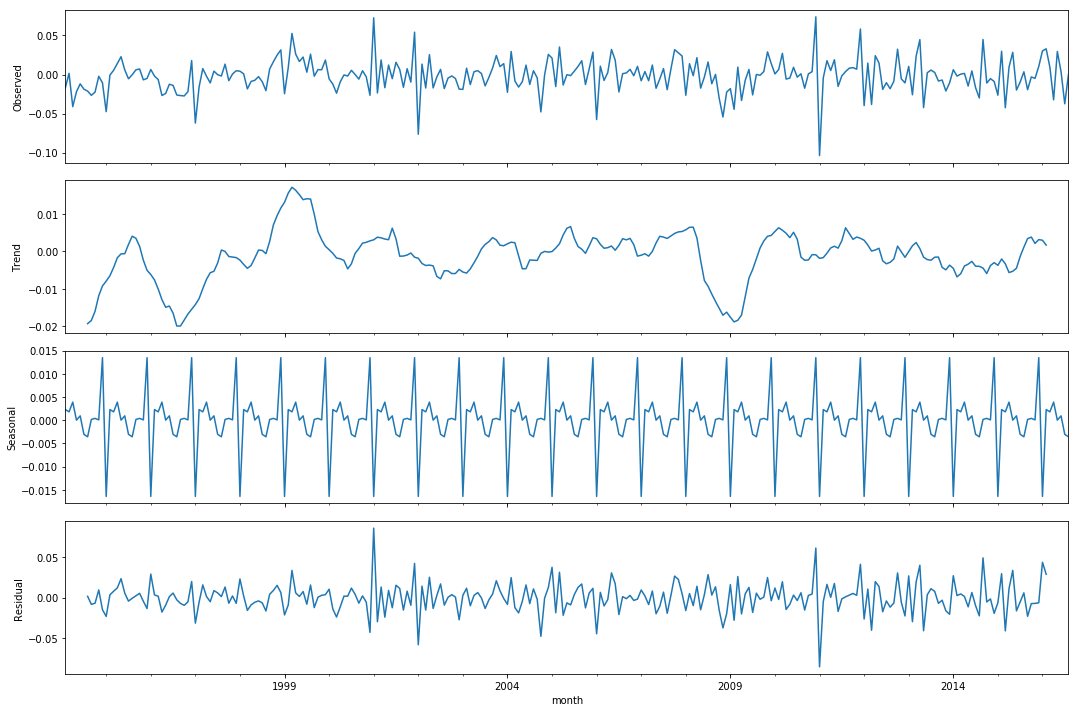

In [17]:
salary['salary_box_diff2'] = salary.salary_box_diff - salary.salary_box_diff.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(salary.salary_box_diff2[13:]).plot()   
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary.salary_box_diff2[13:])[1])

Гипотеза нестационарности отвергается, и визуально ряд выглядит лучше — тренда больше нет. 

## Подбор модели

Посмотрим на ACF и PACF полученного ряда:

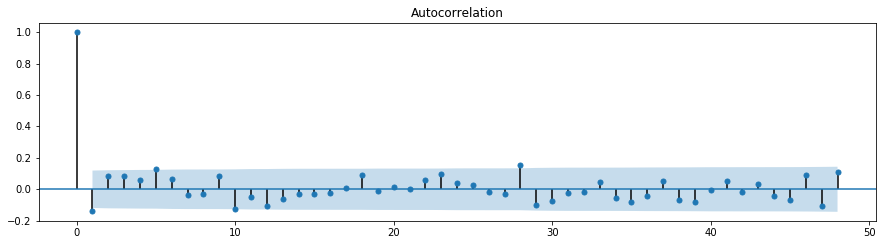

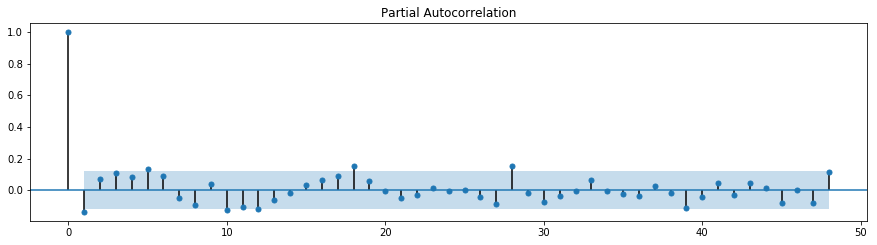

In [19]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(salary.salary_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(salary.salary_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

Начальные приближения: Q=0, q=5, P=5, p=1

In [42]:
ps = range(0, 2)
d=1
qs = range(0, 6)
Ps = range(0, 6)
D=1
Qs = range(0, 2)

In [43]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

144

In [44]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(salary.salary_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

wrong parameters: (0, 0, 0, 0)
wrong parameters: (1, 2, 0, 0)
wrong parameters: (1, 2, 0, 1)
wrong parameters: (1, 2, 1, 0)
wrong parameters: (1, 2, 1, 1)
wrong parameters: (1, 2, 2, 0)
wrong parameters: (1, 2, 2, 1)
wrong parameters: (1, 2, 3, 0)
wrong parameters: (1, 2, 3, 1)
wrong parameters: (1, 2, 4, 0)
wrong parameters: (1, 2, 4, 1)
wrong parameters: (1, 2, 5, 0)
wrong parameters: (1, 2, 5, 1)
CPU times: user 10min 39s, sys: 24.3 s, total: 11min 3s
Wall time: 10min 24s


Если в предыдущей ячейке возникает ошибка, убедитесь, что обновили statsmodels до версии не меньше 0.8.0rc1.

In [45]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

       parameters          aic
120  (1, 5, 0, 1) -1328.770737
123  (1, 5, 2, 0) -1328.104743
122  (1, 5, 1, 1) -1328.067224
121  (1, 5, 1, 0) -1326.563284
119  (1, 5, 0, 0) -1326.186121


Лучшая модель:

In [46]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                         salary_box   No. Observations:                  284
Model:             SARIMAX(1, 1, 5)x(0, 1, 1, 12)   Log Likelihood                 672.385
Date:                            Tue, 26 Dec 2017   AIC                          -1328.771
Time:                                    20:59:38   BIC                          -1299.579
Sample:                                01-01-1993   HQIC                         -1317.067
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5652      0.147      3.837      0.000       0.276       0.854
ma.L1         -0.7783      0.148   

Её остатки:

Критерий Дики-Фуллера: p=0.000000


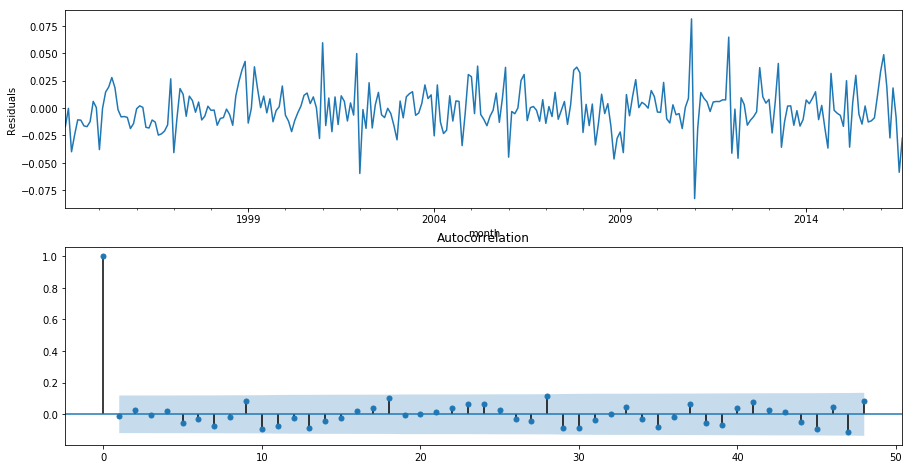

In [48]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Остатки стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой).
Посмотрим, насколько хорошо модель описывает данные:

/Users/alexkirnas/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:13: RuntimeWarning: invalid value encountered in log


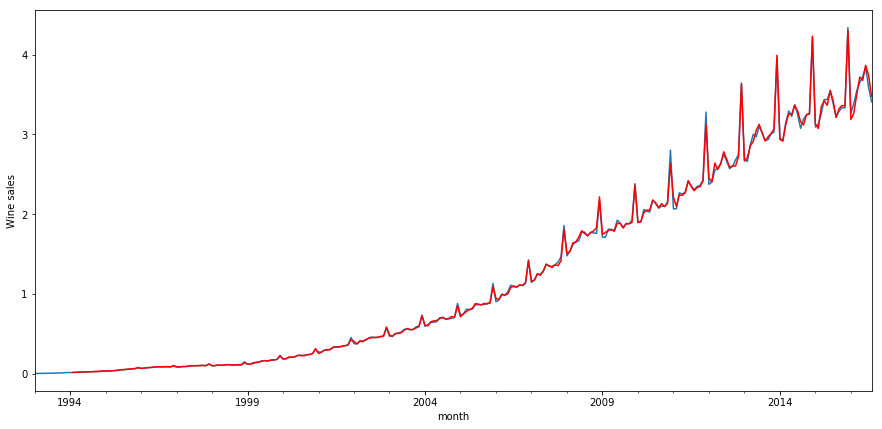

In [49]:
salary['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
salary.WAG_C_M.plot()
salary.model[13:].plot(color='r')
plt.ylabel('Wine sales')
pylab.show()

### Прогноз

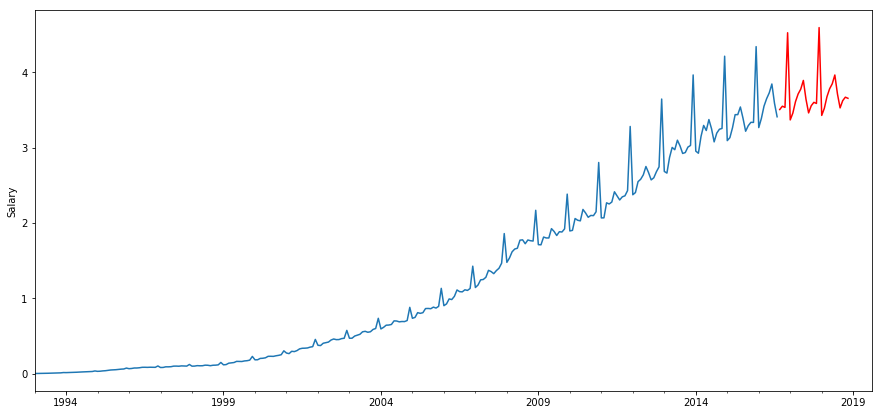

In [50]:
salary2 = salary[['WAG_C_M']]
date_list = [datetime.datetime.strptime("2016-09-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,36)]
future = pd.DataFrame(index=date_list, columns=salary2.columns)
salary2 = pd.concat([salary2, future])
salary2['forecast'] = invboxcox(best_model.predict(start=284, end=310), lmbda)

plt.figure(figsize(15,7))
salary2.WAG_C_M.plot()
salary2.forecast.plot(color='r')
plt.ylabel('Salary')
pylab.show()